# Pneumonia Detection Using Support Vector Machines and Deep Neural Networks

## Model Description
This model leverages the **DenseNet169** architecture to extract relevant features from X-ray images, with the model's approach being detailed in [this article](https://ieeexplore.ieee.org/stamp/stamp.jsp?tp=&arnumber=8869364). The model integrates a Support Vector Machine (SVM) based on the specifications discussed in the article and combines it with a Deep Neural Network in a stacked ensemble format. This methodology has achieved an **accuracy of 87%** on chest X-ray data.

In [4]:
import tensorflow as tf

from tensorflow.keras.applications import DenseNet169
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D

from sklearn.svm import SVC
import numpy as np

import os

import random

import matplotlib.pyplot as plt

def load_and_preprocess_image(path):
    image = tf.io.read_file(path)
    image = tf.image.decode_png(image, channels=3)
    image = tf.image.resize(image, [224, 224])
    image = tf.keras.applications.densenet.preprocess_input(image)
    return image

def create_densenet_feature_extractor():
    base_model = DenseNet169(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    x = base_model.output
    x = GlobalAveragePooling2D()(x) 
    feature_extractor = Model(inputs=base_model.input, outputs=x)
    return feature_extractor
    
feature_extractor = create_densenet_feature_extractor()

preprocessed_imgs = []

def extract_features(image_paths, y_lst):
    features = []
    for idx, path in enumerate(image_paths):
        if not [file_type for file_type in ["jpeg", "png", "gif", "bmp"] if file_type in path]:
            del y_lst[idx]
        else:
            image = load_and_preprocess_image(path)
            preprocessed_imgs.append(image) 
            image = np.expand_dims(image, axis=0)  
            feature = feature_extractor.predict(image, verbose=0)
            features.append(feature.flatten())
    return np.array(features), np.array(y_lst), features 

labels = ["NORMAL", "PNEUMONIA"]
train_dir = "chest_xray/chest_xray/train/"
train_dir_pneumonia = train_dir + "PNEUMONIA/"
train_dir_normal = train_dir + "NORMAL/"

test_dir = "chest_xray/chest_xray/test/"
val_dir = "chest_xray/chest_xray/val/"

normal_img_lst = [train_dir_normal + path_name for path_name in os.listdir(train_dir_normal)]
pneumonia_img_lst = [train_dir_pneumonia + path_name for path_name in os.listdir(train_dir_pneumonia)]

train_image_paths = normal_img_lst + pneumonia_img_lst
y_lst = [0 for i in range(len(normal_img_lst))] + [1 for i in range(len(pneumonia_img_lst))]

### Extracting Features from Training Set Images

In [5]:
print("Extracting Features...")
X_train, y_train, features_lst = extract_features(train_image_paths, y_lst)
print(X_train.shape, y_train.shape)
print("Extracted training data features successfully")

Extracting Features...
(5216, 1664) (5216,)
Extracted training data features successfully


## Pneumonia in X-ray Images

### Visual Differences on X-ray

- **Normal lungs** are more radiolucent (darker), indicating that fewer X-rays are absorbed, and thus they appear darker on the film.
- **Pneumonia-affected areas** show increased whiteness due to higher absorption of X-rays. This whiteness can indicate several conditions:
  - **Consolidation**: This occurs when airspaces (alveoli) are filled with fluid, pus, blood, cells (including inflammatory cells), or other debris as a response to infection. Seen as dense white areas on X-ray, particularly near the spine, suggesting the involvement of lung lobes closer to the central parts of the chest.
  - **Hilar Enlargement**: Increased whiteness around the hilum (the central triangular section of the lung) can suggest swollen lymph nodes or increased vascular markings, common in infectious conditions like pneumonia.
  - **Atelectasis**: Collapse or incomplete expansion of the lung, often occurring with pneumonia and presenting as increased opacity in the lung fields on an X-ray.

### Confusion with Pleural Effusion

- **Pleural Effusion**: Pneumonia can be complicated by pleural effusion, where fluid accumulates in the pleural space around the lungs, visible as increased whiteness on the X-ray.

### Plots and Image:
- The normal X-ray images (labled **"Normal X-ray 1"** and **"Normal X-ray 2"**) are the two most representative examples of what a healthy lung should look like, while the pneumonia X-ray images (labled **"Pneumonia X-ray 1"** and **"Pneumonia X-ray 2"**) are representative of typical lungs affected by pneumonia.
- The graph (titled "Average Feature Activations") plots the average activation of each feature in the feature map created by DenseNet169

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


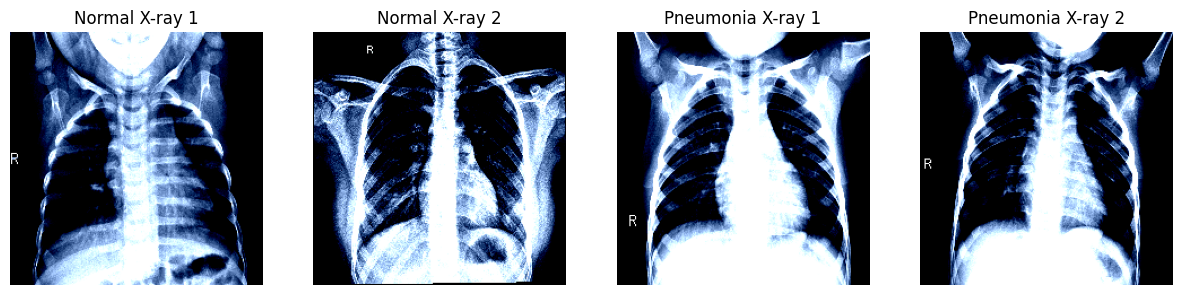

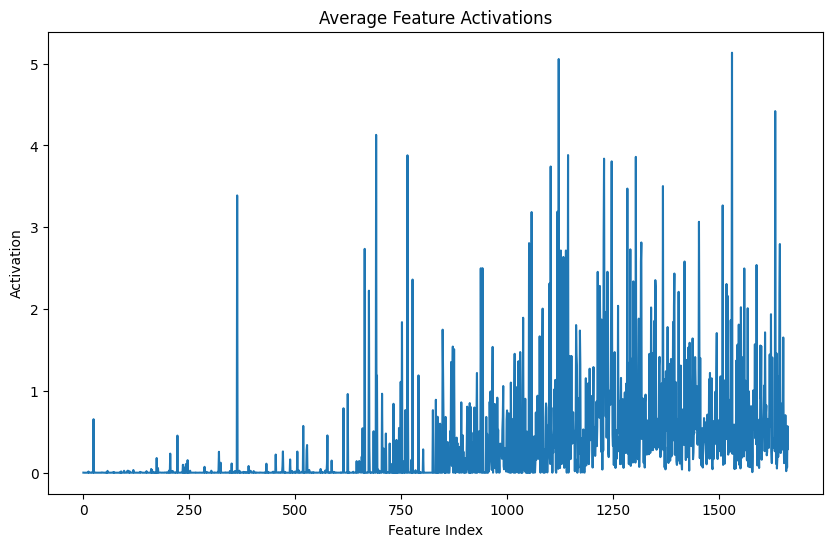

In [6]:
img_before_extraction = preprocessed_imgs[0]
extracted_features = features_lst[-1]

extracted_features_lst = np.array([features_lst[0], features_lst[1], features_lst[-1], features_lst[-2]])
y_indicies = [0, 1, -1, -2]

from sklearn.decomposition import PCA

pca = PCA(n_components=2)
reduced_features = pca.fit_transform(extracted_features_lst)

def display_images(indices):
    normal_cnt = 1
    pneumonia_cnt = 1
    fig, axs = plt.subplots(1, len(indices), figsize=(15, 10))
    for i, idx in enumerate(indices):
        img = preprocessed_imgs[idx]
        y = y_lst[y_indicies[idx]]
        axs[i].imshow(img, cmap='gray')
        axs[i].axis('off')
        if y == 0:
            axs[i].set_title(f'Normal X-ray {normal_cnt}')
            normal_cnt += 1
        else:
            axs[i].set_title(f'Pneumonia X-ray {pneumonia_cnt}')
            pneumonia_cnt += 1
    plt.show()

extreme_indices = [np.argmin(reduced_features[:, 0]), np.argmax(reduced_features[:, 0]),
                   np.argmin(reduced_features[:, 1]), np.argmax(reduced_features[:, 1])]
display_images(extreme_indices)

mean_features = np.mean(features_lst, axis=0)

plt.figure(figsize=(10, 6))
plt.plot(mean_features)
plt.title('Average Feature Activations')
plt.xlabel('Feature Index')
plt.ylabel('Activation')
plt.show()

### Fitting SVM to Training Data

In [7]:
svm_classifier = SVC(kernel='linear')
svm_classifier.fit(X_train, y_train)
print("Model trained successfully")

Model trained successfully


In [8]:
test_normal_dir = test_dir + "NORMAL/"
test_pneumonia_dir = test_dir + "PNEUMONIA/"

normal_test_imgs = [test_normal_dir + path_name for path_name in os.listdir(test_normal_dir)]
pneumonia_test_imgs = [test_pneumonia_dir + path_name for path_name in os.listdir(test_pneumonia_dir)]

test_image_paths = normal_test_imgs + pneumonia_test_imgs
test_labels = [0] * len(normal_test_imgs) + [1] * len(pneumonia_test_imgs)

print("Extracting Features...")
X_test, y_test, test_features_lst = extract_features(test_image_paths, test_labels)
print("Extracted testing data features successfully")

Extracting Features...
Extracted testing data features successfully


In [9]:
predicted_labels = svm_classifier.predict(X_test)

### Accuracy Report for SVM

In [10]:
from sklearn.metrics import accuracy_score, classification_report

accuracy = accuracy_score(y_test, predicted_labels)
print(f"Accuracy: {accuracy:.2f}")

report = classification_report(y_test, predicted_labels, target_names=['Normal', 'Pneumonia'])
print(report)

Accuracy: 0.80
              precision    recall  f1-score   support

      Normal       0.97      0.49      0.65       234
   Pneumonia       0.76      0.99      0.86       390

    accuracy                           0.80       624
   macro avg       0.87      0.74      0.76       624
weighted avg       0.84      0.80      0.78       624



### Performing Grid Search

In [11]:
from sklearn.model_selection import GridSearchCV

param_grid = [
    {"C":[1, 10, 100, 1000], "kernel":["linear"]},
    {"C":[1, 10, 100, 1000], "kernel":["rbf"], "gamma":[0.001, 0.0001]},
    {"C":[1, 10, 100, 1000], "kernel":["rbf"], "gamma":[0.001, 0.0001], "degree":[3, 4, 5]}
]

print("Grid Search Started...")
svm_classifier = SVC()
grid_search = GridSearchCV(svm_classifier, param_grid, cv=5, scoring="accuracy", verbose=1)
grid_search.fit(X_train, y_train)

Grid Search Started...
Fitting 5 folds for each of 36 candidates, totalling 180 fits


GridSearchCV(cv=5, estimator=SVC(),
             param_grid=[{'C': [1, 10, 100, 1000], 'kernel': ['linear']},
                         {'C': [1, 10, 100, 1000], 'gamma': [0.001, 0.0001],
                          'kernel': ['rbf']},
                         {'C': [1, 10, 100, 1000], 'degree': [3, 4, 5],
                          'gamma': [0.001, 0.0001], 'kernel': ['rbf']}],
             scoring='accuracy', verbose=1)

### Graphing Grid Search

The graph below illustrates the accuracies of various parameter combinations tested during the grid search. The parameters had a minimal impact on accuracy. The optimal parameters, which achieved a cross-validation score of 0.98, were a 'C' value of 10 and a 'gamma' value of 0.001 using the 'rbf' kernel. This model used the same kernel as the one proposed in the [previously mentioned article](https://ieeexplore.ieee.org/stamp/stamp.jsp?tp=&arnumber=8869364), but with different 'C' and 'gamma' values.

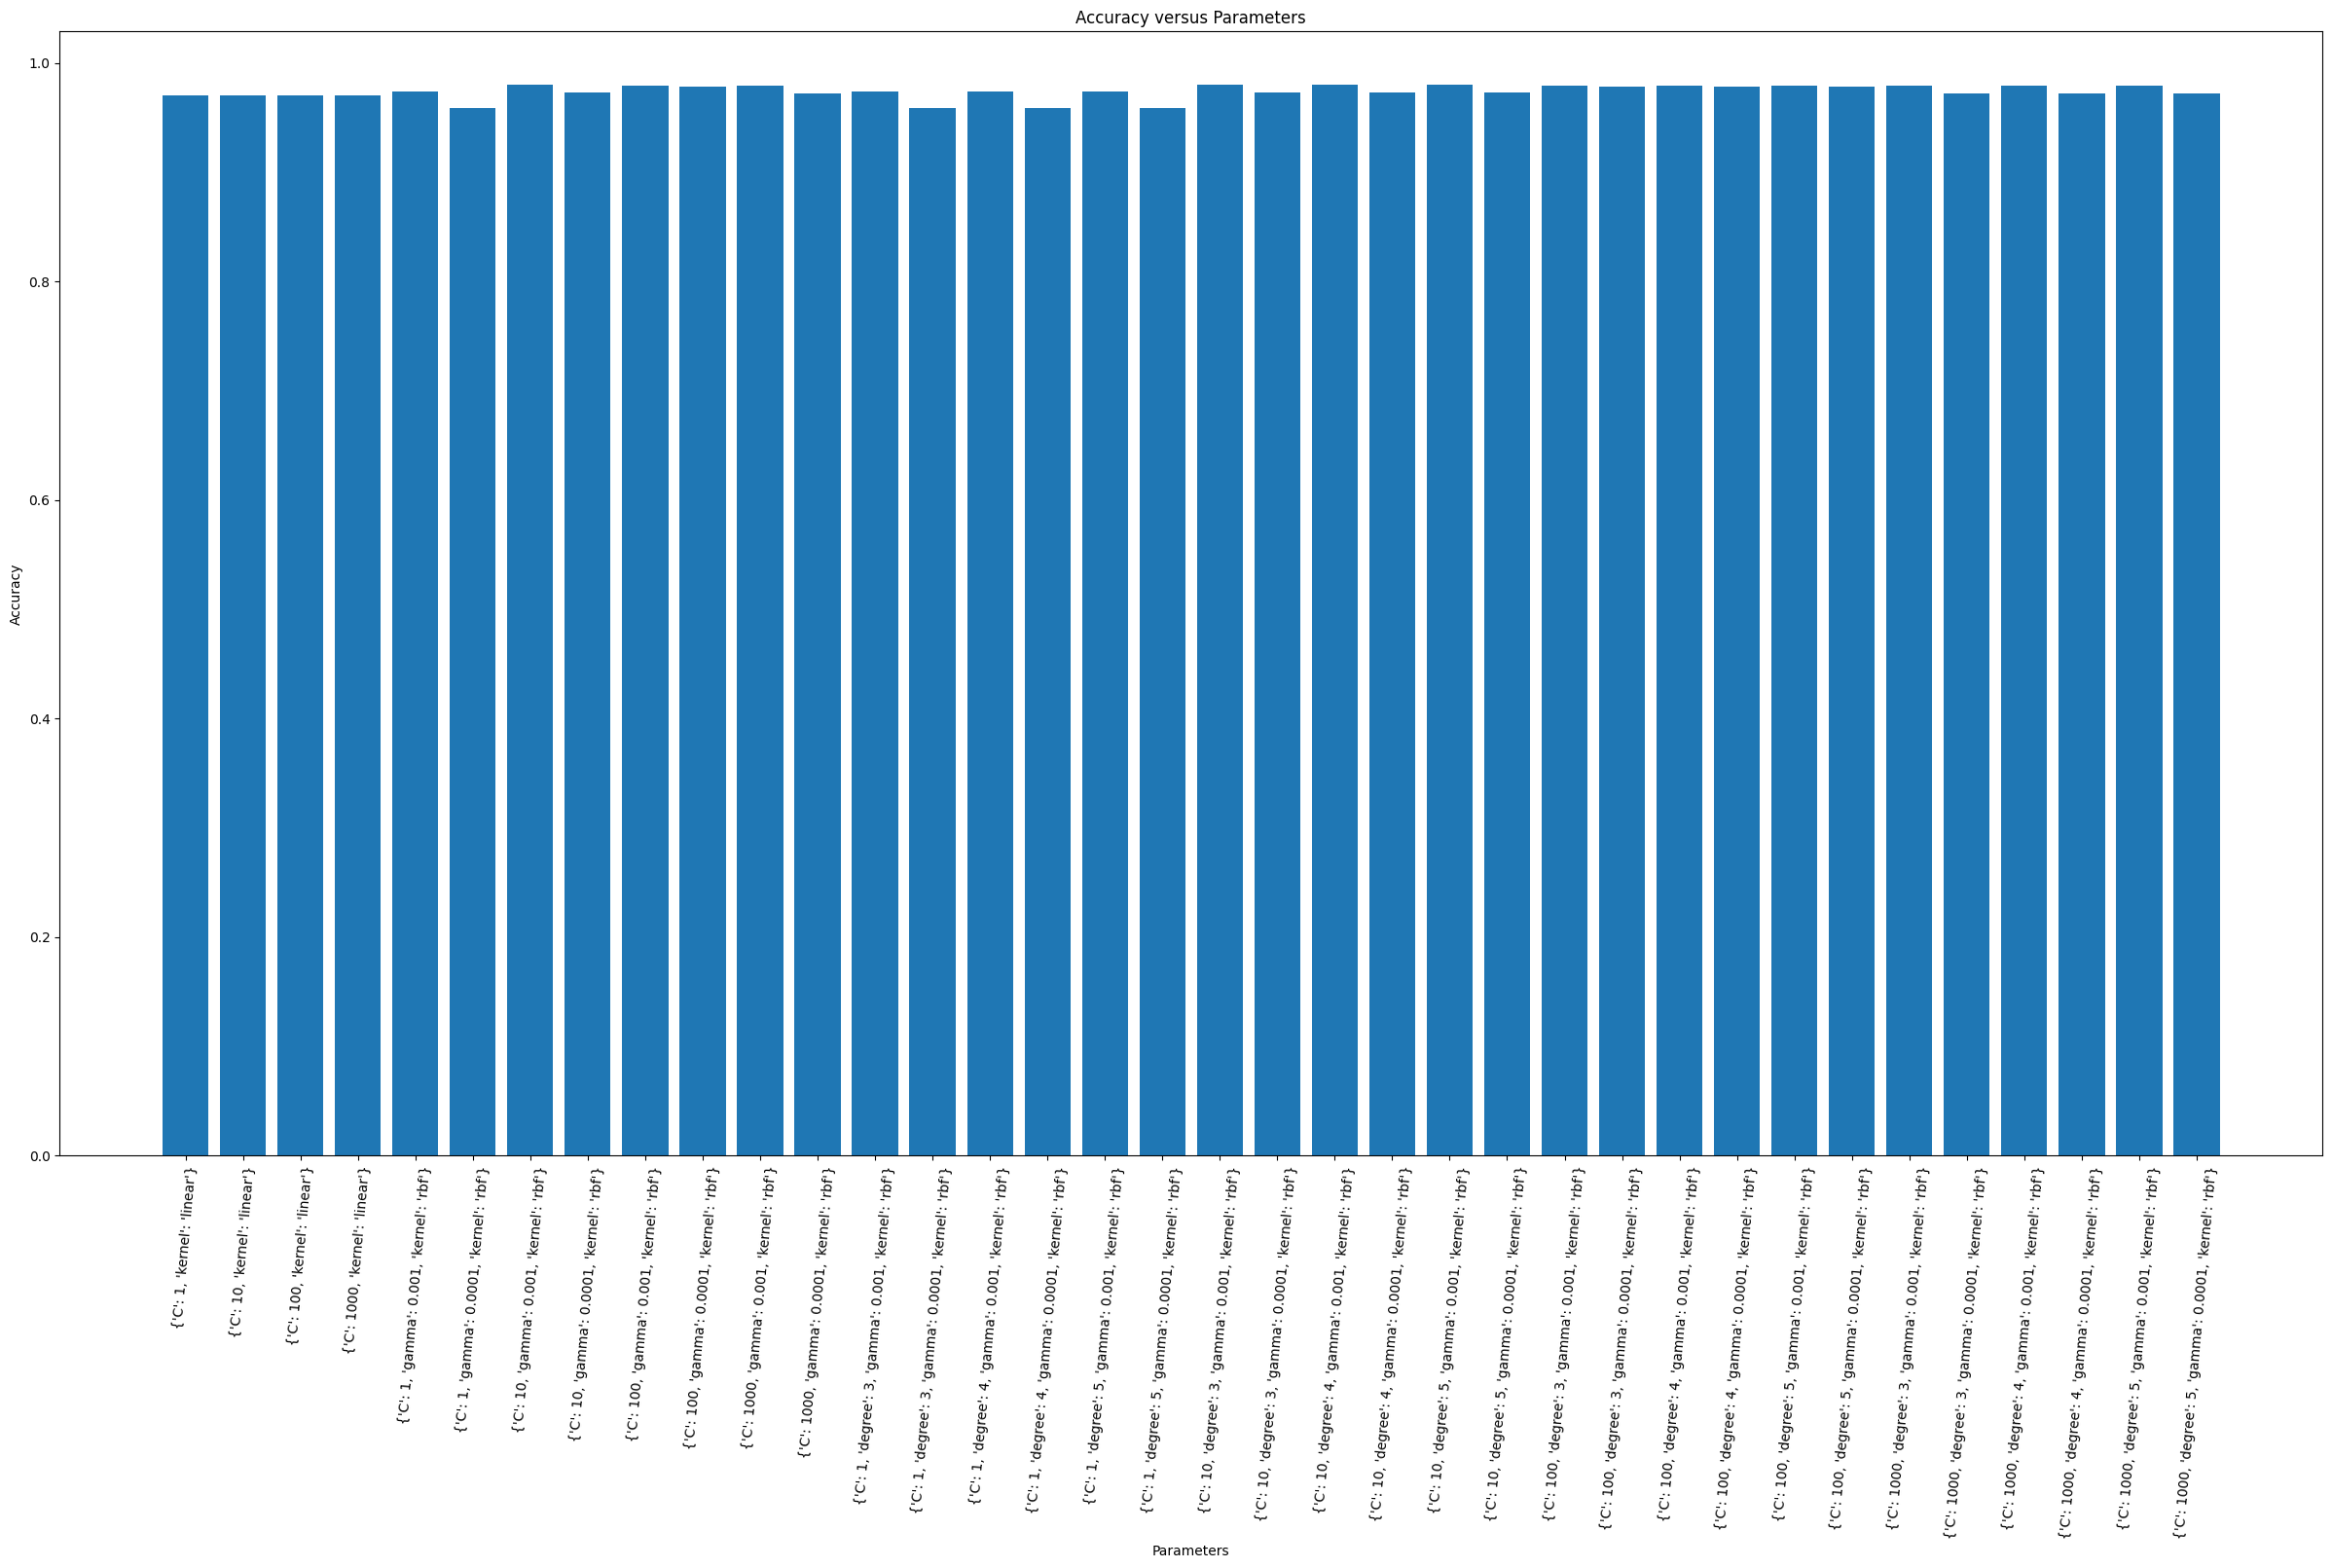

In [12]:
results = grid_search.cv_results_
params_lst = [str(dct) for dct in results['params']]
scores_lst = results['mean_test_score']

plt.figure(figsize=(30, 15))  
plt.bar(params_lst, scores_lst)
plt.title('Accuracy versus Parameters')
plt.xlabel('Parameters')
plt.ylabel('Accuracy')
plt.xticks(rotation=85)
plt.show()

In [13]:
print("Best Parameter:", grid_search.best_params_)
print("Best cross-validation score: {:.2f}".format(grid_search.best_score_))

Best Parameter: {'C': 10, 'gamma': 0.001, 'kernel': 'rbf'}
Best cross-validation score: 0.98


In [14]:
predicted_labels = grid_search.predict(X_test)

### Accuracy Report for Grid Search

In [15]:
accuracy = accuracy_score(y_test, predicted_labels)
print(f"Accuracy: {accuracy:.2f}")

report = classification_report(y_test, predicted_labels, target_names=labels)
print(report)

Accuracy: 0.82
              precision    recall  f1-score   support

      NORMAL       0.97      0.53      0.69       234
   PNEUMONIA       0.78      0.99      0.87       390

    accuracy                           0.82       624
   macro avg       0.87      0.76      0.78       624
weighted avg       0.85      0.82      0.80       624



### Constructing Deep Neural Network
- Input layer has a shape of 1664 for 1664 features
- Dropout rate of 0.3 drops out roughly a third of the input data to prevent overfitting

In [69]:
import tensorflow as tf
from tensorflow.keras import layers

deep_model = tf.keras.models.Sequential([
    layers.Input(shape=(1664,)), 
    layers.Dense(1024, activation='relu'), 
    layers.BatchNormalization(),  
    layers.Dropout(0.3),  

    layers.Dense(512, activation='relu'),  
    layers.BatchNormalization(), 
    layers.Dropout(0.3),

    layers.Dense(256, activation='relu'),  
    layers.BatchNormalization(),  
    layers.Dropout(0.3), 

    layers.Dense(128, activation='relu'), 
    layers.BatchNormalization(),  
    layers.Dropout(0.3),

    layers.Dense(1, activation='sigmoid')  
])

print("Model created successfully.")

Model created successfully.


### Model Architecture

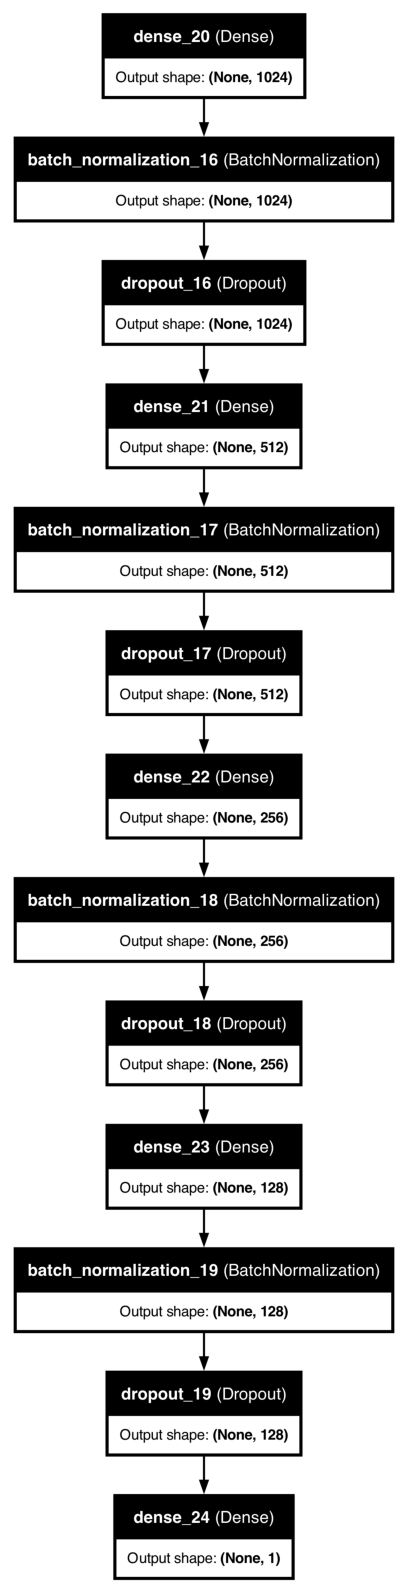

In [70]:
from keras.utils import plot_model
from PIL import Image

plot_model(deep_model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

image = Image.open('model_plot.png')
image = np.array(image)

plt.figure(figsize=(5, 30))
plt.imshow(image)
plt.axis('off') 
plt.show()

### Fitting Deep Neural Network to Training Data

In [84]:
from tensorflow.keras.callbacks import EarlyStopping

print("Training...")
deep_model.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

early_stopping = EarlyStopping(monitor='loss', patience=10, restore_best_weights=True)
deep_model.fit(X_train, y_train, epochs=100, callbacks=[early_stopping])
print("Deep NN trained successfully")

Training...
Epoch 1/100
163/163 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.9907 - loss: 0.0321
Epoch 2/100
163/163 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9871 - loss: 0.0311
Epoch 3/100
163/163 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9882 - loss: 0.0363
Epoch 4/100
163/163 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9931 - loss: 0.0219
Epoch 5/100
163/163 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9949 - loss: 0.0234
Epoch 6/100
163/163 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9949 - loss: 0.0194
Epoch 7/100
163/163 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9956 - loss: 0.0134
Epoch 8/100
163/163 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9911 - loss: 0.0241
Epoch 9/100
163/163 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9942 - loss: 0.0174
Epoch 10/100
163/163 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9920 - loss: 0.0273
Epoch 11/100
163/163 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9960 - loss: 0.0133
Epoch 12/100
163/163 ━━━━━━━━

In [85]:
predicted_labels = deep_model.predict(X_test)

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


### Accuracy Report for Deep Neural Network

In [86]:
predicted_labels = np.rint(predicted_labels).astype(int)

accuracy = accuracy_score(y_test, predicted_labels)
print(f"Accuracy: {accuracy:.2f}")

report = classification_report(y_test, predicted_labels, target_names=['Normal', 'Pneumonia'])
print(report)

Accuracy: 0.87
              precision    recall  f1-score   support

      Normal       0.95      0.68      0.79       234
   Pneumonia       0.84      0.98      0.90       390

    accuracy                           0.87       624
   macro avg       0.89      0.83      0.85       624
weighted avg       0.88      0.87      0.86       624



### Combining the SVM and Deep Neural Network using a Stacked Embedding 

In [87]:
prob_nn = deep_model.predict(X_train) 
decision_scores_svm = grid_search.decision_function(X_train)

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
normalized_scores_svm = scaler.fit_transform(decision_scores_svm.reshape(-1, 1)).flatten()

stacked_features = np.column_stack((prob_nn.flatten(), normalized_scores_svm))

from sklearn.linear_model import LinearRegression

meta_model = LinearRegression()
meta_model.fit(stacked_features, y_train) 

163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


LinearRegression()

In [88]:
prob_nn_test = deep_model.predict(X_test) 
prob_svm_test = grid_search.decision_function(X_test)

normalized_test_scores_svm = scaler.fit_transform(prob_svm_test.reshape(-1, 1)).flatten()

stacked_test_features = np.column_stack((prob_nn_test.flatten(), normalized_test_scores_svm))

final_predictions = meta_model.predict(stacked_test_features)

threshold = 0.5
class_predictions = (final_predictions > threshold).astype(int)

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


In [89]:
accuracy = accuracy_score(y_test, class_predictions)
print(f"Accuracy: {accuracy:.2f}")

report = classification_report(y_test, class_predictions, target_names=['Normal', 'Pneumonia'])
print(report)

Accuracy: 0.87
              precision    recall  f1-score   support

      Normal       0.95      0.68      0.79       234
   Pneumonia       0.84      0.98      0.90       390

    accuracy                           0.87       624
   macro avg       0.89      0.83      0.85       624
weighted avg       0.88      0.87      0.86       624

